In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy
import cupy as cp

import sscCdi
from sscCdi import *
sscCdi.__version__

'0.10.0'

### Nearfield Ptychography  

In [49]:
def RAAR_multiplane(diffraction_patterns,positions,obj,probe,inputs,delta_z_threshold=0):
    
    iterations = inputs['iterations']
    beta       = inputs['beta']
    epsilon    = inputs['epsilon']
    dx         = inputs['object_pixel']
    wavelength = inputs['wavelength']
    distance   = inputs['detector_distance']
    n_of_modes = inputs["incoherent_modes"]
    fresnel_regime = inputs["fresnel_regime"]
    probe_support  = inputs["probe_support"] 

    if fresnel_regime == True:
        pass
    else:
        inputs['source_distance'] = None

    diffraction_patterns = cp.array(diffraction_patterns) 
    positions = cp.array(positions)
    obj = cp.array(obj)
    probe = cp.array(probe)

    if probe_support is None:
        probe_support = cp.ones_like(probe)
    else:
        probe_support = cp.array(probe_support)

    obj_matrix = cp.ones((n_of_modes,obj.shape[-2],obj.shape[-1]),dtype=complex) 
    obj_matrix[:] = obj # create matrix of repeated object to facilitate slice-wise product with probe modes
    
    shapey,shapex = probe.shape
    
    probe_modes = cp.empty((n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex)
    for i in range(0,probe_modes.shape[0]):
        if i == 0:
            probe_modes[i] = probe
        else:
            probe_modes[:] = cp.random.rand(*probe.shape)
    
    # inputs["detector_position"] = np.max(positions[:,2] )    
        
    mean_z_values = get_mean_z_values(positions) # get a mean value for the z_position at each plane. this is used to propagate object between planes
    print(mean_z_values)
    error = cp.zeros((iterations,1))

    print(f'Performing ptychography over {int(positions[:,3].max())} planes')
    
    for iteration in range(0,iterations):
        """
        RAAR update function:
        psi' = [ beta*(Pf*Rr + I) + (1-2*beta)*Pr ]*psi
        psi' = beta*(Pf*Rr + I)*psi + (1-2*beta)*Pr*psi
        psi' = beta*(Pf*Rr*psi + psi) + (1-2*beta)*Pr*psi (eq 1)
        """

        for plane_number in range(0,1+int(positions[:,3].max())): # ptycho at plane z
            
            print(f"\tPtycho @ plane #{plane_number}")
            
            positions_current_plane = positions[positions[:,3]==plane_number] # get positions only for desired z-plane
            data_current_plane = diffraction_patterns[positions[:,3]==plane_number] # get DP only for desired z-plane
            
            # inputs["detector_distance"] = inputs["detector_position"] - positions_current_plane[0,2] # new distance between sample and detector   
            wavefronts = cp.ones((positions_current_plane.shape[0],n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex) # wavefronts contain the wavefront for each probe mode, and for all probe positions
            
            for index, (pos_x, pos_y, pos_z,_) in enumerate(positions_current_plane): # get wavefronts at new z-position
                obj_box = obj_matrix[:,pos_y:pos_y + shapey , pos_x:pos_x+ shapex]
                wavefronts[index] = probe_modes*obj_box

            for index in range(positions_current_plane.shape[0]):

                posx,posy,posz = positions_current_plane[:,0], positions_current_plane[:,1], positions_current_plane[:,2]
                
                obj_box = obj_matrix[:,posy[index]:posy[index] + shapey , posx[index]:posx[index]+ shapex]

                psi_after_Pr = probe_modes*obj_box

                psi_after_reflection_Rspace = 2*psi_after_Pr-wavefronts[index]
                psi_after_projection_Fspace, _ = update_exit_wave_multiprobe_cupy(psi_after_reflection_Rspace,diffraction_patterns[index],inputs) # Projection in Fourier space
                wavefronts[index] = beta*(wavefronts[index] + psi_after_projection_Fspace) + (1-2*beta)*psi_after_Pr 

            probe_modes, single_obj_box = projection_Rspace_multiprobe_RAAR_cupy(wavefronts,obj_matrix[0],probe_modes,positions_current_plane[:,0:2],epsilon) # Update Object and Probe! Projection in Real space (consistency condition)
            obj_matrix[:] = single_obj_box # update all obj slices to be the same;

            fig, ax = plt.subplots(1,4,dpi=150)
            a = obj_matrix[0].get()
            b = probe_modes[0].get()
            ax[0].imshow(np.abs(a))
            ax[1].imshow(np.angle(a))
            ax[2].imshow(np.abs(b))
            ax[3].imshow(np.angle(b))            
            plt.show()
            
            probe_modes = probe_modes[:]*probe_support
            
            if plane_number != int(positions[:,3].max()): # if not last plane
                distance_to_next_plane = mean_z_values[plane_number+1] - mean_z_values[plane_number]
                print('\tPropagating to next plane', distance_to_next_plane) # Propagate object to next plane
                obj_matrix[:] = fresnel_propagator_cone_beam(obj_matrix[0],inputs["wavelength"],inputs["detector_pixel_size"],distance_to_next_plane) # propagate obj_matrix to new plane in parallel geometry

        iteration_error = get_magnitude_error(diffraction_patterns,wavefronts[:,0,:,:],inputs) # should we insert more modes to calculate error?

        # print('\r', end='')
        print(f'Iteration {iteration+1}/{iterations} \tError: {iteration_error:.2e}')

        error[iteration] = iteration_error

    return obj_matrix[0].get(), probe_modes.get(), error.get()


def get_equivalent_geometry(positions,z1z2):
    """
    Equivalent geometry according to: Near-field multi-slice ptychography: quantitative phase imaging of optically thick samples with visible light and X-rays
    """
    
    z1 = positions[:,2].max()
    z2 = z1z2 - z1
    T = z1 - positions[:,2].min()
    dz = z2 - positions[:,2]
    Mdz = (z1+z2)/(z1-dz)
    positions = np.hstack((positions,dz.reshape(-1, 1),Mdz.reshape(-1, 1),np.zeros_like(dz).reshape(-1, 1)))

    delta_z_threshold = 0.0005

    plane_number = 0
    positions[0,5] = 0
    for i in range(0,positions.shape[0]-1):
        diff = positions[i,2] - positions[i+1,2]
        if diff  > delta_z_threshold:
            plane_number +=1
        positions[i+1,5] = plane_number

    # positions[:,2] -= z1z2 # change origin to the detector plane
    # positions[:,2] *= -1
    # positions[:,2] = positions[:,2]*positions[:,4] # change z values to equivalent geometry
    # positions[:,0] = positions[:,0]*positions[:,4] # change x values to equivalent geometry
    # positions[:,1] = positions[:,1]*positions[:,4] # change y values to equivalent geometry
    # positions[:,2] *= -1 # change origin back to focus
    # positions[:,2] += z1z2

    return positions[:,[0,1,2,5]]


def get_mean_z_values(positions_selected):
    mean_z_values = []
    for i in range(0,int(positions_selected[:,3].max()+1)):
        mean_z_position = positions_selected[positions_selected[:, 3] == i][:,2].mean()
        mean_z_values.append(mean_z_position)
    return mean_z_values

### Load Data

[[-0.00200836 -0.00427054 -0.00018443]
 [-0.00200825 -0.00427054  0.00052781]
 [-0.00200815 -0.00427055  0.00129023]
 ...
 [-0.00189938 -0.00428152 -0.00672195]
 [-0.00189928 -0.00428152 -0.00672195]
 [-0.00189918 -0.00428152 -0.00672195]]


((19680, 4),
 11.0,
 array([[-2.008356e-03, -4.270541e-03, -1.844260e-04,  0.000000e+00],
        [-2.008251e-03, -4.270544e-03,  5.278110e-04,  0.000000e+00],
        [-2.008147e-03, -4.270548e-03,  1.290231e-03,  0.000000e+00],
        ...,
        [-1.899381e-03, -4.281519e-03, -6.721945e-03,  1.100000e+01],
        [-1.899279e-03, -4.281520e-03, -6.721945e-03,  1.100000e+01],
        [-1.899176e-03, -4.281519e-03, -6.721946e-03,  1.100000e+01]]))

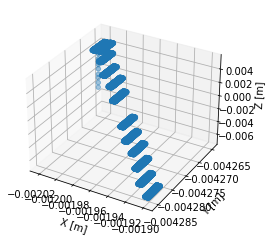

In [50]:
empty = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/empty.npy')
positions0 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/positions.npy')*1e-3
print(positions0)

folder_path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/'
data_shape = (2048,2048)
n_points_per_z = 41*40
n_of_z = 12

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(positions0[:,0],positions0[:,1],positions0[:,2],'o')
ax.set_xlabel('X [m]'), ax.set_ylabel('Y [m]'), ax.set_zlabel('Z [m]')

z1z2 = 1
positions = get_equivalent_geometry(positions0,z1z2)
positions.shape, positions[:,3].max(), positions

### Load data

In [51]:
A = 1 # wanted number of z positions

DPs_selected = np.empty((0,2048,2048),dtype=np.uint16)
positions_selected = np.empty((0,4))

for i in range(0,A):
    data = np.load(folder_path+f"z_{i}.npy")
    print(f"Data #{i} shape = {data.shape}. {data.shape[0]*data.shape[1]}")
    DP = data.reshape(n_points_per_z,data_shape[0],data_shape[1])
    positions1 = positions[i*n_points_per_z:(i+1)*n_points_per_z]
    print(f"Positions #{i} shape = {positions1.shape}")    
    if i == 0:
        DP = DP[10:] # remove weird first points
        positions1 = positions1[10:]  
        
    DPs_selected = np.concatenate((DPs_selected,DP),axis=0)    
    positions_selected = np.concatenate((positions_selected,positions1),axis=0)    

Data #0 shape = (41, 40, 2048, 2048). 1640
Positions #0 shape = (1640, 4)


In [52]:
# np.save('positions.npy',positions_selected)
# np.save('DPs_selected.npy',DPs_selected)
# DPs_selected = np.load('DPs_selected.npy')
# positions_selected = np.load('positions.npy')

DPs_selected.shape, positions_selected.shape,positions_selected    

((1630, 2048, 2048),
 (1630, 4),
 array([[-0.00200732, -0.00427055,  0.00527003,  0.        ],
        [-0.00200722, -0.00427055,  0.00527006,  0.        ],
        [-0.00200712, -0.00427055,  0.00527007,  0.        ],
        ...,
        [-0.00200395, -0.00426649,  0.0052701 ,  0.        ],
        [-0.00200385, -0.00426649,  0.00527011,  0.        ],
        [-0.00200375, -0.00426649,  0.0052701 ,  0.        ]]))

In [53]:
# sscCdi.slice_visualizer(DPs_selected)

### Call Ptychography

z1=0.005270114, z2=0.994729886, M=189.74921605111388
Minimal required distance from focus = 1.742mm
Object pixel = 1.44e-06 m
Probe shape = (2048, 2048)
All positions:  (1630, 4)
[[2.34273924e+02 1.00000000e+02 5.27002800e-03 0.00000000e+00]
 [2.47714494e+02 1.00131770e+02 5.27005700e-03 0.00000000e+00]
 [2.61418604e+02 1.00131770e+02 5.27007100e-03 0.00000000e+00]
 ...
 [6.78339798e+02 6.34987373e+02 5.27010500e-03 0.00000000e+00]
 [6.91780368e+02 6.34855603e+02 5.27010600e-03 0.00000000e+00]
 [7.05352707e+02 6.34723832e+02 5.27010500e-03 0.00000000e+00]]
Deleting 1530 slices


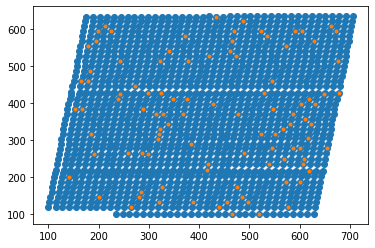

Size of the array: 0.78125 GB
Object shape = (2925, 2882)
FOV = [4212.   4150.08] um2
Data shape = (100, 2048, 2048)
Positions shape = (100, 4)
[array(0.00527011)]
Performing ptychography over 0 planes
	Ptycho @ plane #0


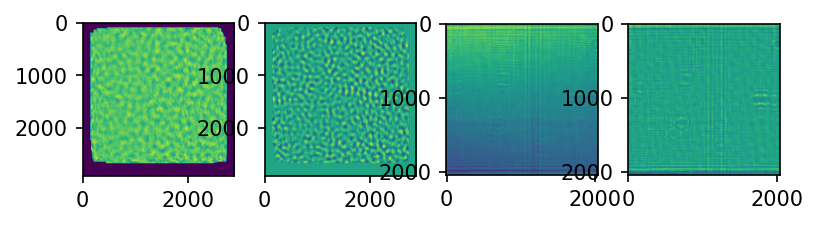

Iteration 1/10 	Error: 1.32e-03
	Ptycho @ plane #0


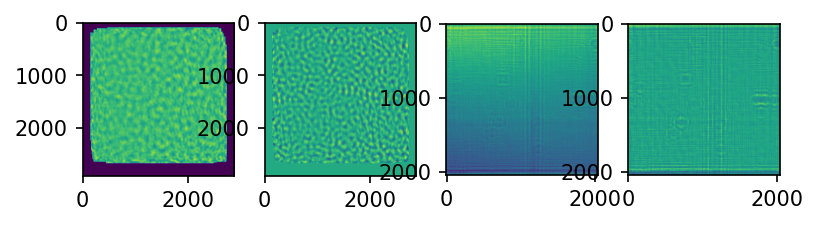

Iteration 2/10 	Error: 1.32e-03
	Ptycho @ plane #0


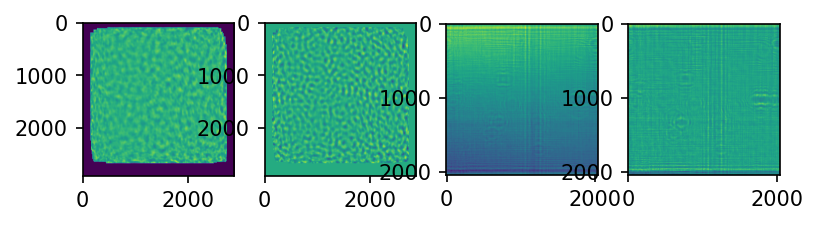

Iteration 3/10 	Error: 1.32e-03
	Ptycho @ plane #0


In [ ]:
try:
    import cupy as cp
    cp.cuda.memory.MemoryPool().free_all_blocks()
except:
    print('exception')
    
positions = positions_selected.copy()

z1 = np.max(positions[:,2])
z2 = 1 - z1
M0 = (z2+z1)/z1
print(f'z1={z1}, z2={z2}, M={M0}')

c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_position": z2*M0,    
"detector_distance": z2*M0,    
"detector_pixel_size": 1.44e-6, # PCO pixel size with lens 
"source_distance": 0, # should be 0 if parallel beam
}

positions[:,0:2] *= M0
# print(positions[0,2]*M0)

wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength

waist = 250e-9/2
zmin = 2*np.pi*waist**2/wavelength
print(f'Minimal required distance from focus = {zmin*1e3:.3f}mm')

inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')

# positions[:,0] = positions_selected[:,1]
# positions[:,1] = positions_selected[:,0]

probe = np.ones_like(empty)
print(f'Probe shape = {probe.shape}')

inputs["object_padding"] = 100
positions[:,0:2] = sscCdi.convert_probe_mogno_positions_meters_to_pixels(positions[:,0:2].copy(),inputs["object_pixel"],inputs["object_padding"])
positions[:,3] = np.round(positions[:,3])
print('All positions: ', positions.shape)
print(positions)

N = 40
fig, ax = plt.subplots()
ax.plot(positions[:,0],positions[:,1],'o')

if 1: # remove random points from data
    n_of_points_to_keep = 100
    start_idx = positions.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    positions = np.delete(positions,slices_to_ignore,axis=0)
    DPs = np.delete(DPs_selected,slices_to_ignore,axis=0)

# np.save('positions2.npy',positions)
# np.save('DPs_selected2.npy',DPs)
# positions = np.load('positions2.npy')
# DPs = np.load('DPs_selected2.npy')

ax.plot(positions[:,0],positions[:,1],'.')
plt.show()

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

object_padding = 200
inputs["object_shape"] = sscCdi.set_object_shape(object_padding, DPs.shape, positions[:,0:2])
# inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')
print(f'FOV = {np.asarray(inputs["object_shape"])*inputs["object_pixel"]*1e6} um2')
print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
# probe_guess = DPs.mean(0)
obj_guess = np.ones_like(model_object) # constant object

inputs['iterations'] = 10   
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.001 # RAAR; small value to add to probe/object update denominator

# print(positions.shape, DPs.shape, probe_guess.shape, obj_guess.shape, inputs)
RAAR_obj, RAAR_probes, _ = RAAR_multiplane(DPs,positions,obj_guess,probe_guess,inputs)

5.6356453357367875e-11 1.44e-06 -0.5026631269654084 0.0


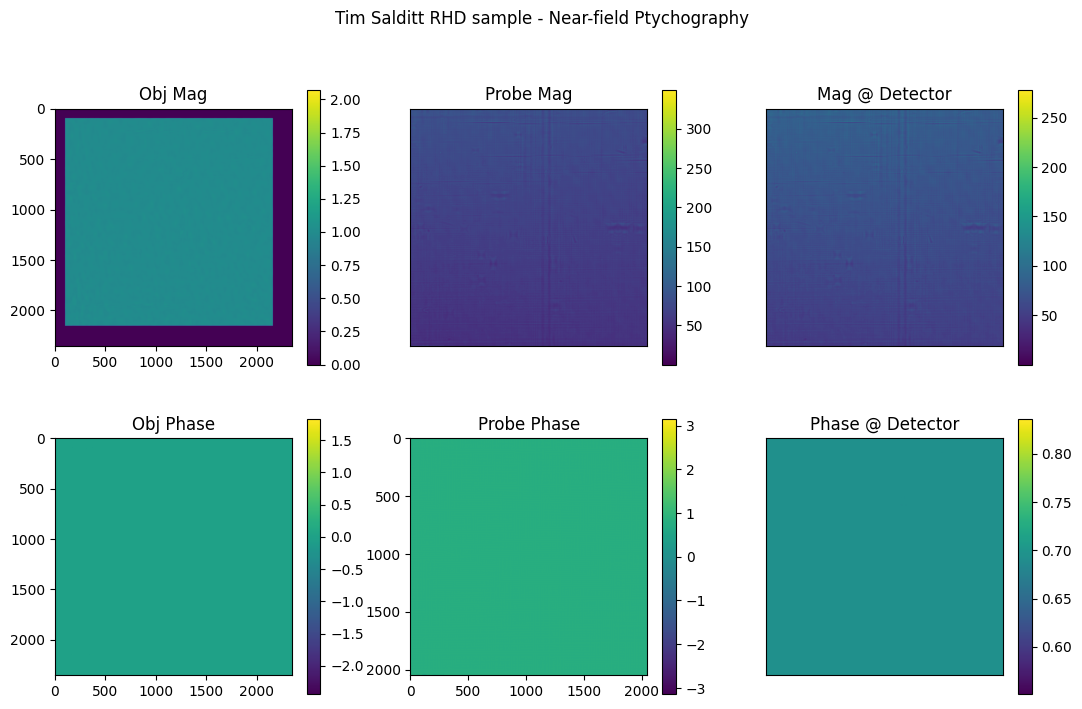

((2351, 2350), (1, 2048, 2048))

In [28]:
print(inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"],float(inputs["source_distance"]))
propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"])


if 1: # plot
    fig, ax = plt.subplots(2,3,figsize=(13,8),dpi=100)
    im1=ax[0,0].imshow(np.abs(RAAR_obj))
    ax[0,0].set_title('Obj Mag')
    # ax[0,0].plot(positions[:,0],positions[:,1],'.',color='gray')
    fig.colorbar(im1, ax=ax[0, 0])

    im2 = ax[1,0].imshow(np.angle(RAAR_obj))
    ax[1,0].set_title('Obj Phase')
    fig.colorbar(im2, ax=ax[1, 0])

    im3 = ax[0,1].imshow(np.abs(RAAR_probes[0]))
    ax[0,1].set_title('Probe Mag')
    fig.colorbar(im3, ax=ax[0, 1])

    im4 = ax[1,1].imshow(np.angle(RAAR_probes[0]))
    ax[1,1].set_title('Probe Phase')
    fig.colorbar(im4, ax=ax[1, 1])

    im5=ax[0,2].imshow(np.abs(propagated_probe))
    ax[0,2].set_title('Mag @ Detector')
    fig.colorbar(im5, ax=ax[0, 2])

    mean = np.mean(np.angle(propagated_probe))
    std=np.std(np.angle(propagated_probe))
    im6 = ax[1,2].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std)
    ax[1,2].set_title('Phase @ Detector')
    fig.colorbar(im6, ax=ax[1,2])

    fig.suptitle('Tim Salditt RHD sample - Near-field Ptychography')

    for i, ax in enumerate(ax.ravel()):
        if i==3 or i==0 or i ==4: continue
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

RAAR_obj.shape, RAAR_probes.shape